In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.metrics import accuracy_score

Step 0: load our data

In [3]:
# Load data
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/MSc thesis/processed_data/metadata/fully_concatenated_data.csv", lineterminator='\n')

In [6]:
# List of image and text feature columns to keep
image_columns = [f'image_{i}' for i in range(0, 2049)]
text_columns = [f'text_{i}' for i in range(0, 768)]

# Additional columns you want to keep
additional_columns_to_keep = ['like_count', 'comment_count', 'post_id', 'Followers', 'Username', 'Image_Count', 'Is_English']

# Combine both lists of columns to keep
columns_to_keep = image_columns + additional_columns_to_keep + text_columns

# Drop all columns except those specified in columns_to_keep
columns_to_drop = [col for col in data.columns if col not in columns_to_keep]

# Drop the unwanted columns from the dataframe
data_2 = data.drop(columns=columns_to_drop)


# Maybe don't delete category and detected languages
# Same with comments disabled and video
# potential columns to add or not:
#'comments_disabled',
#'is_video'
# Category
data_2 = data_2[data_2['Image_Count'] <= 1]
data_2.head(10)

,Username,post_id,like_count,comment_count,Followers,Is_English,Image_Count,image_0,image_1,image_2,...,text_758,text_759,text_760,text_761,text_762,text_763,text_764,text_765,text_766,text_767
0,00_rocketgirl,1354915397698488656,293,6,6453,True,1,0.483804,4.411579,0.103043,...,-0.155746,-0.017703,-0.091135,0.058261,0.159358,0.032952,-0.012526,-0.204870,0.062999,0.075272
1,00_rocketgirl,1666974101448132749,73,2,6453,True,1,1.257535,4.292836,0.637026,...,-0.247792,0.015757,-0.037442,-0.018389,0.203054,0.074983,0.049237,-0.213263,-0.012400,0.147600
2,00_rocketgirl,1768273356099895999,164,4,6453,True,1,1.015909,4.928564,0.049328,...,-0.089539,-0.097885,-0.226008,0.053440,0.047846,0.004013,-0.182280,-0.174142,0.094179,0.080168
4,00_rocketgirl,1899586748141399903,116,2,6453,True,1,0.961807,3.994127,0.116529,...,-0.112963,-0.036261,-0.078814,0.114615,0.149342,0.011751,-0.150317,-0.156846,0.141513,0.093924
9,0hkris,1514786978688118458,269,0,12630,True,1,1.316597,1.515859,0.067210,...,-0.147682,-0.036988,-0.208915,0.104713,0.120187,0.093342,0.097392,-0.009471,0.012900,0.064740
10,0hkris,1837331879491417999,1065,19,12630,True,1,1.682237,1.290816,0.079366,...,-0.009259,-0.165627,0.198171,0.093986,0.176528,0.140797,0.070081,-0.168545,0.107152,0.057365
11,0hkris,1840089921320547693,1242,7,12630,True,1,0.923607,3.838140,0.041025,...,-0.092988,-0.083701,0.228142,0.049256,0.080081,0.093756,0.086833,-0.163537,0.100750,0.096130
12,0hkris,1847365723795798774,1346,4,12630,True,1,0.044586,1.376372,0.007699,...,-0.161618,-0.178489,0.159561,-0.046662,0.182022,0.127947,0.299180,-0.091949,0.096147,0.045425
13,0ldisme,1653111532051112326,1139,28,18583,True,1,0.012054,0.549083,0.087380,...,-0.162583,0.028141,-0.179497,0.085646,0.179977,0.134104,0.239402,0.052813,0.030690,-0.044792
14,0ldisme,1708204647056992205,1352,39,18583,True,1,0.587146,4.310180,0.034403,...,-0.114496,-0.001124,-0.172151,0.021455,0.215737,0.150555,0.408500,-0.234415,0.109303,-0.072184


In [7]:
# Filter the DataFrame to keep only observations where 'Is_English' is True
data_2 = data_2[data_2['Is_English'] == True]

Step 1: group and split the data by post_id

Define a popularity variable

In [8]:
# Set the engagement rate variable
data_2['popularity'] = (((data_2['like_count'] + data_2['comment_count'])/data_2['Followers']))

Let's split the data!

In [14]:
# Define the number of iterations and an array to store accuracies
n_iterations = 7
accuracies = []

for seed in range(n_iterations):
    print(f"Iteration {seed+1}")

    # Split users into training and temporary sets with a new seed each time
    train_users, temp_users = train_test_split(data_2['Username'].unique(), test_size=0.2, random_state=seed)
    val_users, test_users = train_test_split(temp_users, test_size=0.5, random_state=seed)

    # Assign posts to training, validation, and test sets
    train_data = data_2[data_2['Username'].isin(train_users)]
    val_data = data_2[data_2['Username'].isin(val_users)]
    test_data = data_2[data_2['Username'].isin(test_users)]

    # Calculate the median popularity rate for each dataset
    median_popularity_rate_train = train_data['popularity'].quantile(0.5)
    train_data.loc[:, 'popularity'] = (train_data['popularity'] > median_popularity_rate_train).astype(int)
    median_popularity_rate_val = val_data['popularity'].quantile(0.5)
    val_data.loc[:, 'popularity'] = (val_data['popularity'] > median_popularity_rate_val).astype(int)
    median_popularity_rate_test = test_data['popularity'].quantile(0.5)
    test_data.loc[:, 'popularity'] = (test_data['popularity'] > median_popularity_rate_test).astype(int)

    # Prepare data for XGBoost
    X_train = train_data.drop(['popularity', 'post_id', 'like_count', 'comment_count', 'Username', 'Image_Count', 'Followers'], axis=1)
    y_train = train_data['popularity']
    X_val = val_data.drop(['popularity', 'post_id', 'like_count', 'comment_count', 'Username', 'Image_Count', 'Followers'], axis=1)
    y_val = val_data['popularity']
    X_test = test_data.drop(['popularity', 'post_id', 'like_count', 'comment_count', 'Username', 'Image_Count', 'Followers'], axis=1)
    y_test = test_data['popularity']

    # Convert datasets into DMatrix objects
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label=y_val)
    dtest = xgb.DMatrix(X_test, label=y_test)

    # Define XGBoost model parameters
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'error',
        'alpha': 0.9,
        'learning_rate': 0.1
    }

    # Train the model
    eval_list = [(dtrain, 'train'), (dval, 'val')]
    bst = xgb.train(params, dtrain, num_boost_round=500, evals=eval_list, early_stopping_rounds=20)

    # Evaluate the model on the test set
    y_pred_prob = bst.predict(dtest)
    y_pred_binary = (y_pred_prob > 0.5).astype(int)
    accuracy = accuracy_score(y_test, y_pred_binary)
    accuracies.append(accuracy)

    print(f"Accuracy for iteration {seed+1}: {accuracy:.2f}")

# Calculate the average accuracy across all iterations
average_accuracy = np.mean(accuracies)
print(f"Average Accuracy across {n_iterations} iterations: {average_accuracy:.2f}")

Iteration 1
[0]	train-error:0.41530	val-error:0.44647
[1]	train-error:0.39765	val-error:0.43494
[2]	train-error:0.39045	val-error:0.43318
[3]	train-error:0.38455	val-error:0.43090
[4]	train-error:0.37934	val-error:0.42641
[5]	train-error:0.37680	val-error:0.42685
[6]	train-error:0.37469	val-error:0.42703
[7]	train-error:0.37141	val-error:0.42650
[8]	train-error:0.36894	val-error:0.42588
[9]	train-error:0.36623	val-error:0.42236
[10]	train-error:0.36268	val-error:0.42280
[11]	train-error:0.36168	val-error:0.42148
[12]	train-error:0.36044	val-error:0.42113
[13]	train-error:0.35825	val-error:0.42113
[14]	train-error:0.35592	val-error:0.42043
[15]	train-error:0.35362	val-error:0.41902
[16]	train-error:0.35193	val-error:0.41920
[17]	train-error:0.34958	val-error:0.41990
[18]	train-error:0.34808	val-error:0.41849
[19]	train-error:0.34547	val-error:0.41955
[20]	train-error:0.34388	val-error:0.41779
[21]	train-error:0.34219	val-error:0.41717
[22]	train-error:0.34174	val-error:0.41541
[23]	trai

In [20]:
# Alternatively, using numpy to generate bootstrap samples and calculate the percentiles
bootstrap_samples = np.random.choice(accuracies, (10000, n), replace=True)
ci_lower = np.percentile(bootstrap_samples, 2.5)
ci_upper = np.percentile(bootstrap_samples, 97.5)

print(f"Bootstrap 95% Confidence Interval: {ci_lower:.5f} - {ci_upper:.5f}")

Bootstrap 95% Confidence Interval: 0.59076 - 0.60267


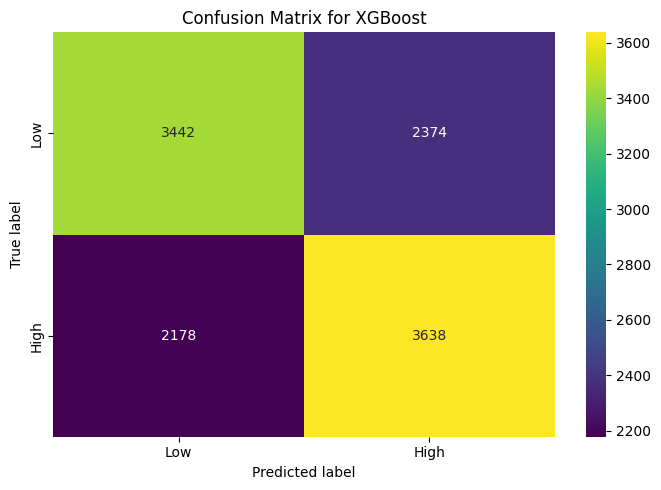

              precision    recall  f1-score   support

         Low       0.61      0.59      0.60      5816
        High       0.61      0.63      0.62      5816

    accuracy                           0.61     11632
   macro avg       0.61      0.61      0.61     11632
weighted avg       0.61      0.61      0.61     11632



In [16]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def evaluate_model(model, X_test, y_test, type_of_model):
    # Convert X_test to DMatrix for XGBoost prediction
    dtest = xgb.DMatrix(X_test)

    # Predicting the probabilities for the test set
    y_pred_prob = model.predict(dtest)

    # Convert probabilities to binary labels
    y_pred = (y_pred_prob > 0.5).astype(int)

    # y_test should already be binary labels
    y_true = y_test.astype(int)

    # Generating the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Generating the classification report
    clr = classification_report(y_true, y_pred, target_names=['Low', 'High'])

    # Plotting the confusion matrix
    plt.figure(figsize=(7, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
    plt.title(f'Confusion Matrix for {type_of_model}')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

    # Show plot
    plt.show()

    # Print the classification report
    print(clr)

# Example usage assuming X_val is a pandas DataFrame and val_data['popularity'] is the true labels
evaluate_model(bst, X_val, val_data['popularity'], 'XGBoost')

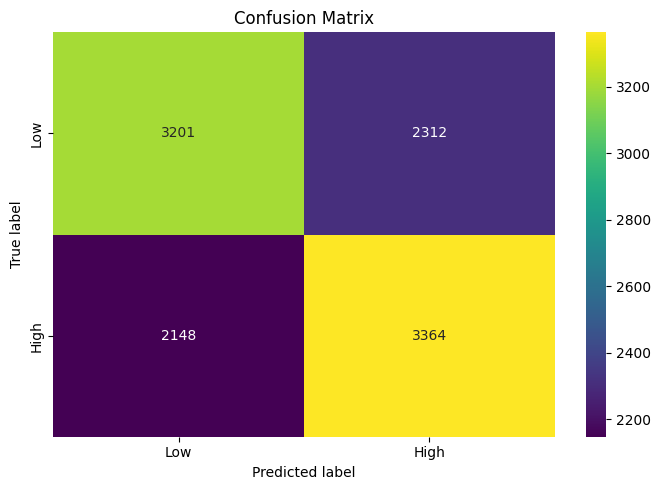

              precision    recall  f1-score   support

         Low       0.60      0.58      0.59      5513
        High       0.59      0.61      0.60      5512

    accuracy                           0.60     11025
   macro avg       0.60      0.60      0.60     11025
weighted avg       0.60      0.60      0.60     11025



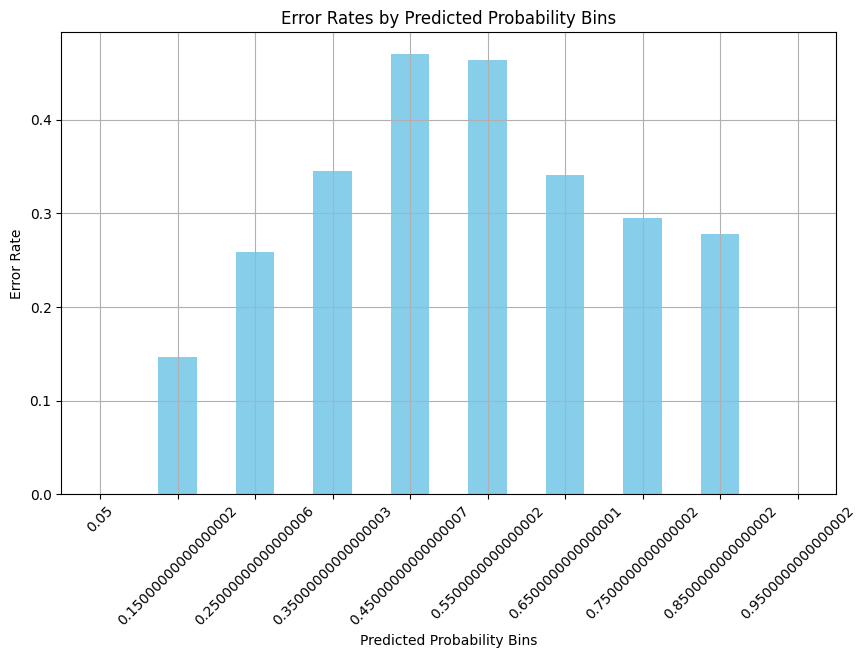

In [17]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def evaluate_model_and_error_rates(model, X_test, y_test):
    # Convert X_test to DMatrix for XGBoost prediction
    dtest = xgb.DMatrix(X_test)

    # Predicting the probabilities for the test set
    y_pred_prob = model.predict(dtest)

    # Convert probabilities to binary labels
    y_pred = (y_pred_prob > 0.5).astype(int)

    # y_test should already be binary labels
    y_true = y_test.astype(int)

    # Generating the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Generating the classification report
    clr = classification_report(y_true, y_pred, target_names=['Low', 'High'])

    # Plotting the confusion matrix
    plt.figure(figsize=(7, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

    # Print the classification report
    print(clr)

    # Calculate error rates by probability bins
    results = pd.DataFrame({
        'y_true': y_true,
        'y_pred_prob': y_pred_prob
    })

    results['prob_bin'] = pd.cut(results['y_pred_prob'], bins=np.arange(0, 1.1, 0.1), labels=np.arange(0.05, 1.05, 0.1))

    # Calculate error rates
    error_rates = results.groupby('prob_bin').apply(
        lambda x: np.mean(x['y_true'] != (x['y_pred_prob'] > 0.5))
    )

    # Plotting error rates by predicted probability bins
    plt.figure(figsize=(10, 6))
    error_rates.plot(kind='bar', color='skyblue')
    plt.title('Error Rates by Predicted Probability Bins')
    plt.xlabel('Predicted Probability Bins')
    plt.ylabel('Error Rate')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

# Example usage, assuming X_test is a pandas DataFrame and test_data['popularity'] is the true labels
evaluate_model_and_error_rates(bst, X_test, test_data['popularity'])